<a href="https://colab.research.google.com/github/chrisrichardson/FEMexamples/blob/main/01%20-%20FEM%20Basics%201D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from numpy import *
set_printoptions(suppress=True, formatter={'all':lambda x: '%5.2f'%x})
import matplotlib.pyplot as plt
from ipywidgets import interact
%matplotlib inline

# Finite Element basics 1D
Let us look at the one-dimensional heat equation. Probably, you will be familiar with the steady-state form:

$$ {d\over dx}\left(k A {dT\over dx}\right) = 0 $$

where $T$ is the temperature, $A$ is the cross-sectional area, and $k$ is the thermal conductivity.

For a simple example, let us solve this equation in a rod of constant cross-sectional area $A$ which extends from $x=0$ to $x=1$, with a thermal conductivity $k$. We can fix the temperature $T=100$ at $x=0$ and $T=0$ at $x=1$. Obviously, this has a trivial, linear, solution, but it is instructive to see how to get a numerical solution with Finite Element, and we can introduce more complexity later.

### Representation of a function by discrete variables

First, let us consider how we can represent $T(x)$ computationally. Simply, we might choose to subdivide the domain $(0,1)$ into $n$ pieces (or "elements"), and represent $T(x)$ as having a continuous, piecewise linear values in each part. For example, suppose $T(x) = \sin(5x)$, and $n=10$.

[ 0.00  0.10  0.20  0.30  0.40  0.50  0.60  0.70  0.80  0.90  1.00]
[ 0.00  0.48  0.84  1.00  0.91  0.60  0.14 -0.35 -0.76 -0.98 -0.96]


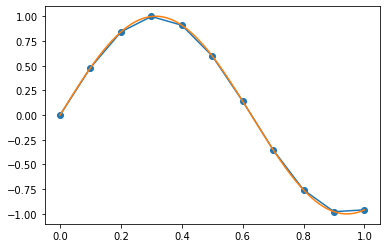

In [2]:
# Create an array of n+1 values for position x, from 0 to 1 inclusive
n = 10
x = linspace(0.0, 1.0, n + 1)
T = sin(5*x)

print(x)
print(T)
plt.plot(x,T, marker='o');

# Plot a more accurate representation
n = 1000
x = linspace(0.0, 1.0, n + 1)
T = sin(5*x)
plt.plot(x,T);


We can build up the "piecewise linear" version of $T(x)$ from the following formula:

$$ T_{piecewise}(x) = \sum_i T_i N_i(x) $$ where $T_i$ are the discrete values of $T$ at each "node" and $N_i$ are functions that are "local" to the node. The functions $N_i(x)$ are called shape functions, and in this case, are just linear between neighbouring nodes: a triangular or tent-like shape. $N_i$ has value 1 at node $i$ and value 0 at all other nodes. The interactive plot below lets you build up $T$ by adding together the contributions from shape functions from 1 to 11

In [3]:
def plot(n):
    x = linspace(0, 1.0, 11)
    T = sin(5*x)
    # Plot T as given by the first 'n' shape functions
    T[n:] = 0.0
    plt.plot(x, T, marker='o', color='k')
    
    # Plot shape function n 
    for i in range(1, n+1):
        Ni = zeros(11)
        Ni[i-1] = 1.0
        plt.plot(x, Ni)
        plt.text(0.1*(i-1), 1, '$N_{%d}$'%(i-1), size=16)
    plt.ylim(-1.5, 1.5)

interact(plot, n=(1,11,1));

interactive(children=(IntSlider(value=6, description='n', max=11, min=1), Output()), _dom_classes=('widget-int…

We can also calculate the derivatives, $$ {d\over dx}T_{piecewise}(x) = \sum_i T_i {dN_i\over dx} $$ 

For these simple shape functions $N_i$, the derivatives are piecewise constant (and hence the second derivative is zero).

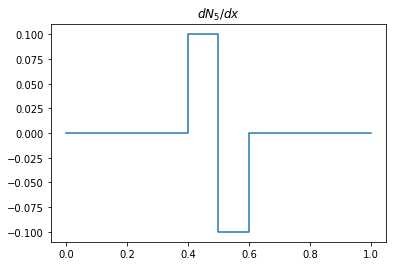

In [ ]:
# For example, dN5/dx looks like this:
x = [0.0, 0.4, 0.4, 0.5, 0.5, 0.6, 0.6, 1.0]
y = [0.0, 0.0, 0.1, 0.1, -0.1, -0.1, 0.0, 0.0]
plt.plot(x, y)
plt.title('$dN_5/dx$')
plt.show()

### Variational method

Returning to the mathematical description of the heat equation,
assuming $k$ and $A$ to be constant, it can also be written as follows,

$$ \int_0^1 w(x) {d\over dx}\left({dT\over dx}\right) dx = 0 $$

simply by multiplying by an arbitrary function $w(x)$ and integrating. At first, there may seem to be little gained by writing it in this way, but by manipulating this equation, we can first simplify, then localise the equation, and make it possible to solve numerically.

Integration by parts gives:

$$ - \int_0^1 {dw\over dx} {dT\over dx} dx + \left[w {dT\over dx}\right]_0^1= 0$$ 

For now, let's consider the integral, and worry about the boundary terms later.

### Finite Element method

For a numerical approximation, we will replace both $w(x)$ and $T(x)$ with piecewise approximations $w_{piecewise}(x), T_{piecewise}(x)$ to get:

$$ \int_0^1 \sum_{i,j} w_i {dN_i\over dx} T_j {dN_j\over dx} dx = 0 $$

Note that we need separate iterators $i$ and $j$ for $w_i$ and $T_j$. If we can solve this equation to get all the $T_j$ values, we will have a numerical solution to the problem.

The derivatives $dN_i\over dx$ are just $+1/\delta x$, $-1/\delta x$, or 0, depending on which segment, or "element" you are in, where $\delta x$ is the spacing between points (0.1 in this case). 

For example, if we take the "element" between 0.4 and 0.5, we see that ${dN_4\over dx} = -{1\over \delta x}$ and ${dN_5\over dx} = {1\over\delta x}$. 

All other derivatives ${dN_i\over dx} = 0$. 

As a result, we can break down the integral into small pieces, over each "element", which are easy to evaluate:

$$ \int_{0.4}^{0.5} \sum_{i,j} w_i  {dN_i\over dx} T_j {dN_j\over dx} dx = {w_4 T_4 - w_4 T_5 - w_5 T_4 + w_5 T_5 \over \delta x^2} \delta x$$ 

$$ \int_{0.5}^{0.6} \sum_{i,j} w_i  {dN_i\over dx} T_j {dN_j\over dx} dx = {w_5 T_5 - w_5 T_6 - w_6 T_5 + w_6 T_6 \over \delta x^2} \delta x$$ 

etc., and we could continue for the whole range from $x=0$ to $x=1$, integrating each element individually, and summing the contributions from each of them. 




We can also write out each integral in a matrix form, like this:

$$ \int_{0.4}^{0.5} \sum_{i,j} w_i  {dN_i\over dx} T_j {dN_j\over dx} dx = {1\over\delta x}(
\begin{array}{cc}
w_4 & w_5 \\
\end{array})
\left(
\begin{array}{cc} 
1 & -1 \\
-1 & 1 \\
\end{array}
\right)
\left(
\begin{array}{c}
T_4 \\
T_5 \\
\end{array}
\right) $$

Summing all the integrals gives the following:

$$ \int_0^1 \sum_{i,j} w_i {dN_i\over dx} T_j {dN_j\over dx} dx = {1\over\delta x} 
[\begin{array}{cccc} 
w_0 & w_1 & \cdots & w_n 
\end{array}]
\left(
\begin{array}{cccccc}
1 & -1 & 0 & 0 & 0 & \cdots & 0 \\
-1 & 2 & -1 & 0 & 0 & \cdots & 0 \\
0 & -1 & 2 & -1 & 0 & \cdots & 0 \\
\cdots & & & & \\
\end{array}\right)
\left(
\begin{array}{c}
T_0 \\ T_1 \\ \cdots \\ \cdots \\ T_n
\end{array}
\right) = \left(\begin{array}{c}0\\0\\ \cdot\\ \cdot\\ 0 \end{array}\right)
$$

Because of the arbitrariness of $w(x)$ and hence $w_i$, we can consider each $w_i$ in turn, and assume all the other $w_{j\neq i} = 0$. Each row of the matrix, multiplied by the vector $T$ must be zero in turn, and we can discard $w$ altogether. We have thus reduced the problem to a matrix equation $A.T = 0$ where $A$ in this case is tridiagonal. Note that we could have got the same matrix equation from a finite-difference approximation.

#### Boundary Conditions
Above, we ignored the $[w dT/dx]_0^1$ term, and so far, we haven't specified any boundary condition. Since $w$ is arbitrary, we can just let it be zero, and ignore this term. This is equivalent to a "natural" or "Neumann" boundary condition. If we wish to impose a hard or "Dirichlet" boundary condition, we will have to do something to our matrix above. For example, if we wish $T_0$ to be zero, we can clear the first row of the matrix, and set the diagonal to 1. Let's fully illustrate the example by solving the problem with the Dirichlet BCs described above.

In [ ]:
# Set up matrix problem A.T = b (where T is the unknown temperature)

# Full matrix, as shown above
A = zeros((11, 11))
# Element matrix, representing laplace operator on each element
Ke = array([[1.0, -1.0], 
            [-1.0, 1.0]])
# Insert element matrix into full matrix 10 times
for i in range(10):
    A[i:i+2, i:i+2] += Ke
print('A = \n', A, '\n')

# Right hand side vector (zero)
b = zeros(11)

# Introduce a source term on the RHS(!)
b += 0

# Clear a row and set diagonal to one, for Dirichlet BC
# Set BC T=100 at x=0
A[0, :] = 0.0
A[0, 0] = 1.0
b[0] = 100.0

# Set BC T=0 at x=1
A[10, :] = 0.0
A[10, 10] = 1.0
b[10] = 0.0

print('Modified A = \n', A, '\n')
print('RHS b = ', b)

from numpy.linalg import solve
T = solve(A, b)

print('Solution T =', T)

A = 
 [[ 1.00 -1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [-1.00  2.00 -1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -1.00  2.00 -1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00 -1.00  2.00 -1.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00 -1.00  2.00 -1.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00 -1.00  2.00 -1.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00 -1.00  2.00 -1.00  0.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00 -1.00  2.00 -1.00  0.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00 -1.00  2.00 -1.00  0.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -1.00  2.00 -1.00]
 [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00 -1.00  1.00]] 

Modified A = 
 [[ 1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [-1.00  2.00 -1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00 -1.00  2.00 -1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0

As predicted, the solution is linear.

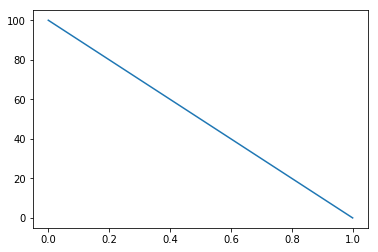

In [ ]:
x = linspace(0.0, 1.0, 11)
plt.plot(x,T)
plt.show()